## Density Plot used in Manuscript

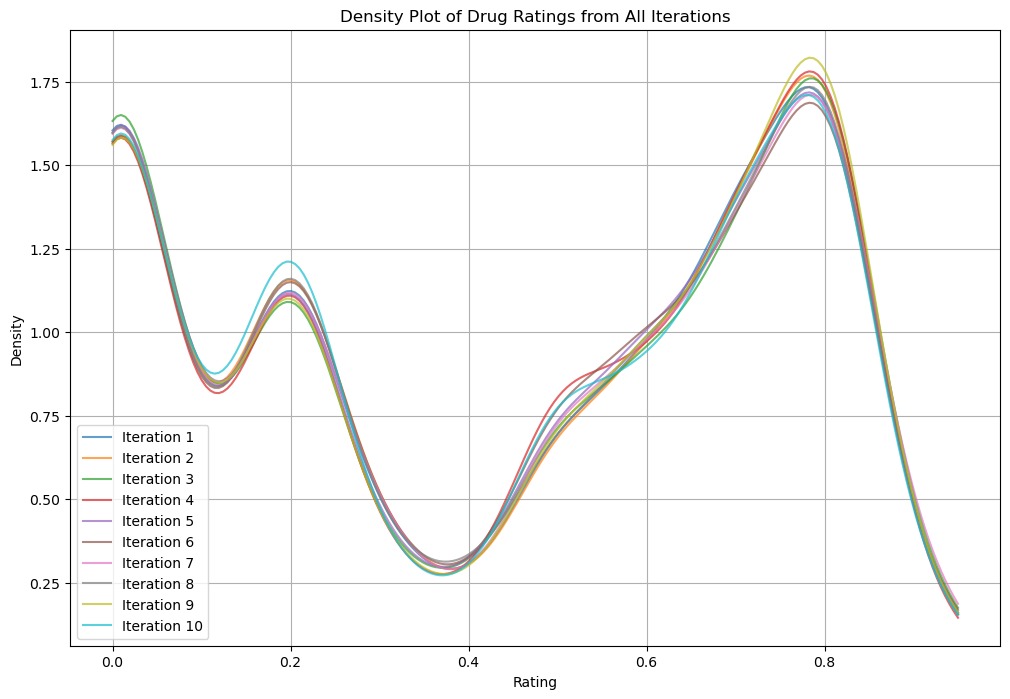

In [4]:
import os
from neo4j import GraphDatabase
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Load environment variables from .env file
load_dotenv()

def fetch_ratings(uri, user, password, rating_properties):
    ratings = {prop: [] for prop in rating_properties}
    try:
        driver = GraphDatabase.driver(uri, auth=(user, password))
        
        with driver.session() as session:
            for prop in rating_properties:
                result = session.run(f"""
                    MATCH (d:Drug)
                    WHERE d.{prop} IS NOT NULL
                    RETURN d.{prop} AS rating
                """)
                ratings[prop] = [record['rating'] for record in result]
            return ratings

    except Exception as e:
        print(f"An error occurred: {e}")
        return {prop: [] for prop in rating_properties}
    finally:
        if 'driver' in locals():
            driver.close()

def plot_density_plots(ratings, custom_labels):
    plt.figure(figsize=(12, 8))
    
    for i, (prop, values) in enumerate(ratings.items()):
        # Convert to numeric and drop non-numeric values
        df = pd.DataFrame(values, columns=[prop])
        df[prop] = pd.to_numeric(df[prop], errors='coerce')
        df = df.dropna()

        if not df.empty:  # Only plot if there's data left after cleaning
            density = gaussian_kde(df[prop])
            xs = np.linspace(min(df[prop]), max(df[prop]), 200)
            label = custom_labels.get(prop, prop)
            plt.plot(xs, density(xs), label=label, alpha=0.7)
    
    plt.title('Density Plot of Drug Ratings from All Iterations')
    plt.xlabel('Rating')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Connection details
uri = os.getenv("uri")
user = os.getenv("username")
password = os.getenv("password")

# List of rating properties to compare
rating_properties = ['rating_0', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9']  # Add more as needed

# Dictionary mapping original rating property names to custom labels
custom_labels = {
    'rating_0': 'Iteration 1',
    'rating_1': 'Iteration 2',
    'rating_2': 'Iteration 3',
    'rating_3': 'Iteration 4',
    'rating_4': 'Iteration 5',
    'rating_5': 'Iteration 6',
    'rating_6': 'Iteration 7',
    'rating_7': 'Iteration 8',
    'rating_8': 'Iteration 9',
    'rating_9': 'Iteration 10'
}

# Fetch ratings and plot density plots
ratings = fetch_ratings(uri, user, password, rating_properties)
if any(ratings.values()):  # Check if there's any rating data
    plot_density_plots(ratings, custom_labels)
